In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl
import ast

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

# IMPORTANDO DADOS

In [2]:
df = pd.read_csv('DataBase.csv')
df

,time,vy,px,py,pz,pitch,roll,yaw,wz,vz,wx,wy,ax,ay,az,vx
0,4.605,-1.822504,15.92092,-3.937876,-2.395700,-0.387166,2.234169,1.381564,0.709883,6.860315,2.527116,2.436048,-5.020252,1.442169,7.631299,5.582263
1,4.625,-1.758280,16.19357,-4.027396,-2.043278,-0.423595,2.293710,1.369977,0.595209,7.236569,2.317435,2.332035,-5.332967,1.126794,7.418851,5.323432
2,4.645,-1.707028,16.45294,-4.114028,-1.672537,-0.455642,2.351147,1.355192,0.483437,7.593075,2.105176,2.212257,-5.547138,0.923290,6.841394,5.051430
3,4.665,-1.664287,16.69833,-4.198311,-1.284677,-0.483349,2.406080,1.337760,0.371447,7.921332,1.895621,2.080593,-5.935756,0.786340,6.288874,4.764358
4,4.685,-1.632485,16.92916,-4.280731,-0.880968,-0.506887,2.458164,1.318146,0.256947,8.227038,1.693481,1.941733,-5.884880,0.485767,5.939368,4.468842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5651,121.220,5.679904,1599.33400,-370.382000,4580.170000,-0.045417,1.933988,0.250601,-0.023054,-12.407120,-0.008522,0.000118,-0.014196,-0.018842,-0.020855,9.982707
5652,121.240,5.678581,1599.83400,-370.098100,4579.549000,-0.045370,1.933818,0.250146,-0.023129,-12.408140,-0.008769,0.000175,-0.007432,-0.034092,-0.020012,9.982166
5653,121.260,5.676628,1600.33300,-369.814200,4578.929000,-0.045321,1.933647,0.249690,-0.023169,-12.409100,-0.008894,0.000270,-0.006416,-0.044052,-0.018600,9.981820
5654,121.280,5.674312,1600.83200,-369.530400,4578.308000,-0.045270,1.933476,0.249234,-0.023202,-12.410060,-0.008919,0.000358,-0.008487,-0.048584,-0.019612,9.981447


# NORMALIZANDO DADOS

In [3]:
print('Average Sample Time:', float(np.round(df.time.diff().median(), 3)), 'seg')
dt = 0.020

Average Sample Time: 0.02 seg


In [4]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,vy,px,py,pz,pitch,roll,yaw,wz,vz,wx,wy,ax,ay,az,vx
0,0.00,-1.822504,15.92092,-3.937876,-2.395700,-0.387166,2.234169,1.381564,0.709883,6.860315,2.527116,2.436048,-5.020252,1.442169,7.631299,5.582263
1,0.02,-1.758280,16.19357,-4.027396,-2.043278,-0.423595,2.293710,1.369977,0.595209,7.236569,2.317435,2.332035,-5.332967,1.126794,7.418851,5.323432
2,0.04,-1.707028,16.45294,-4.114028,-1.672537,-0.455642,2.351147,1.355192,0.483437,7.593075,2.105176,2.212257,-5.547138,0.923290,6.841394,5.051430
3,0.06,-1.664287,16.69833,-4.198311,-1.284677,-0.483349,2.406080,1.337760,0.371447,7.921332,1.895621,2.080593,-5.935756,0.786340,6.288874,4.764358
4,0.08,-1.632485,16.92916,-4.280731,-0.880968,-0.506887,2.458164,1.318146,0.256947,8.227038,1.693481,1.941733,-5.884880,0.485767,5.939368,4.468842


# VETORIZAÇÃO

In [5]:
aData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.ax, df.ay, df.az)])
wData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.wx, df.wy, df.wz)])
tData = df.time.to_numpy()
aData[:5]

array([[-5.020252 ,  1.442169 ,  7.631299 ],
       [-5.332967 ,  1.126794 ,  7.418851 ],
       [-5.547138 ,  0.9232901,  6.841394 ],
       [-5.935756 ,  0.78634  ,  6.288874 ],
       [-5.88488  ,  0.485767 ,  5.939368 ]])

# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

In [6]:
def plotData(time, data, range=None):
    keys, values = list(data.keys()), list(data.values())
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(time, values[0])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[0]}$'), plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(time, values[1])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[1]}$'), plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(time, values[2])
    if range: plt.xlim(range)
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[2]}$'), plt.grid()
    plt.show()

### Aceleração Linear

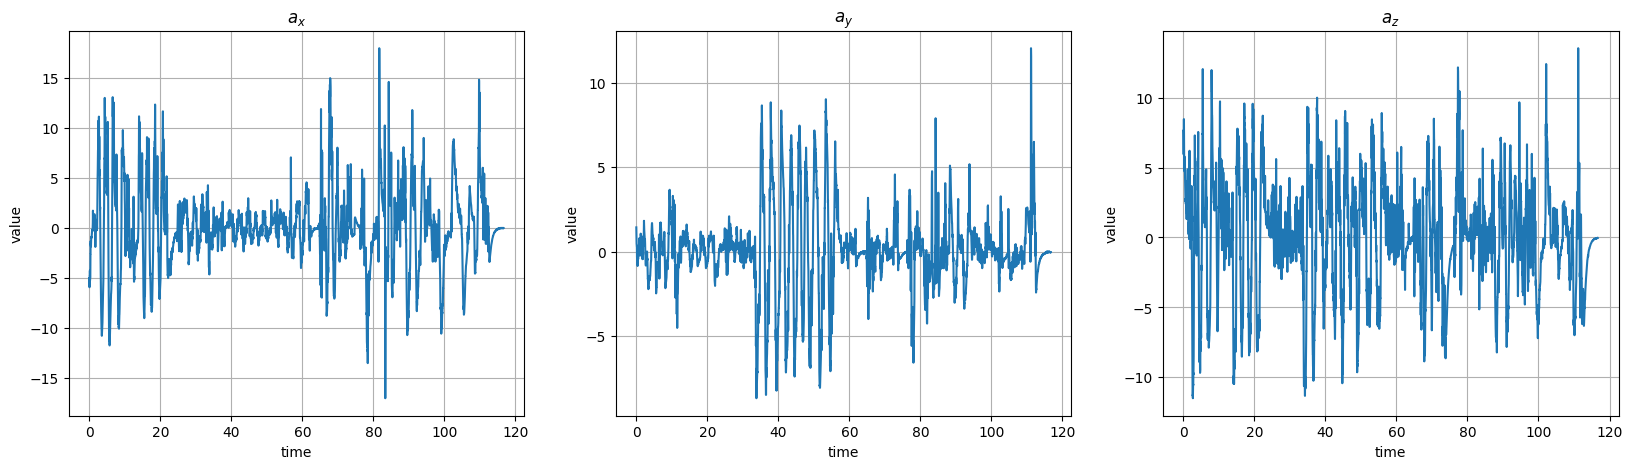

In [7]:
plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
})

### Velocidade Linear

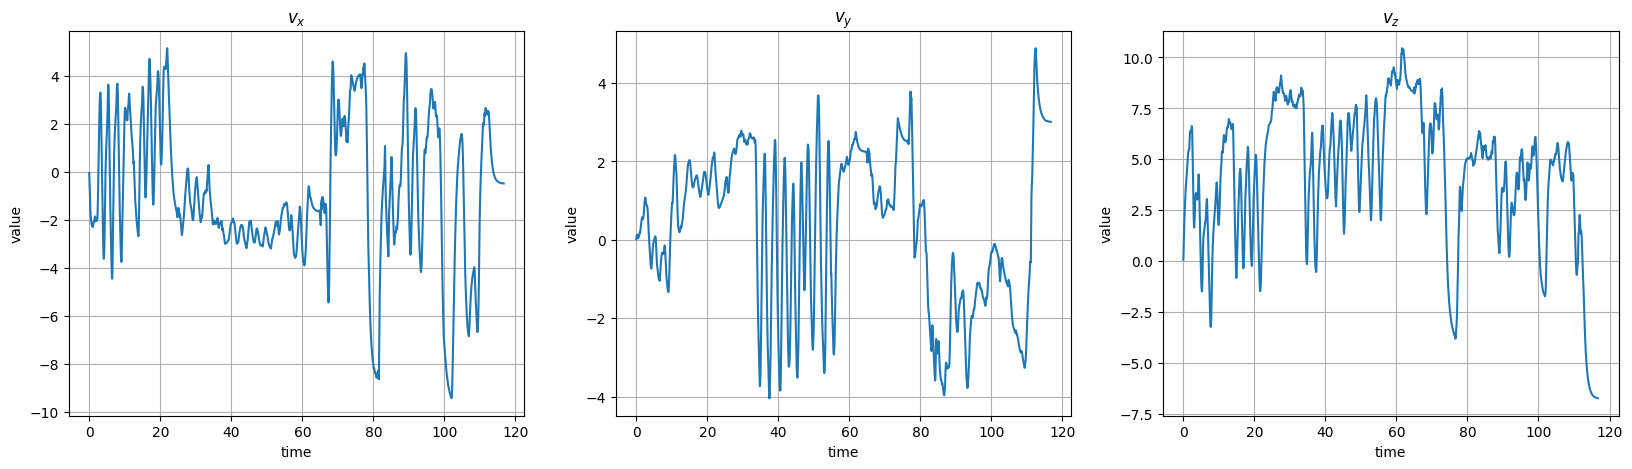

In [8]:
vData = np.column_stack([
    Integral(dt).apply([ax for (ax, ay, az) in aData]),
    Integral(dt).apply([ay for (ax, ay, az) in aData]),
    Integral(dt).apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'v_x': [vx for (vx, vy, vz) in vData],
    'v_y': [vy for (vx, vy, vz) in vData],
    'v_z': [vz for (vx, vy, vz) in vData],
})

### Posição Linear

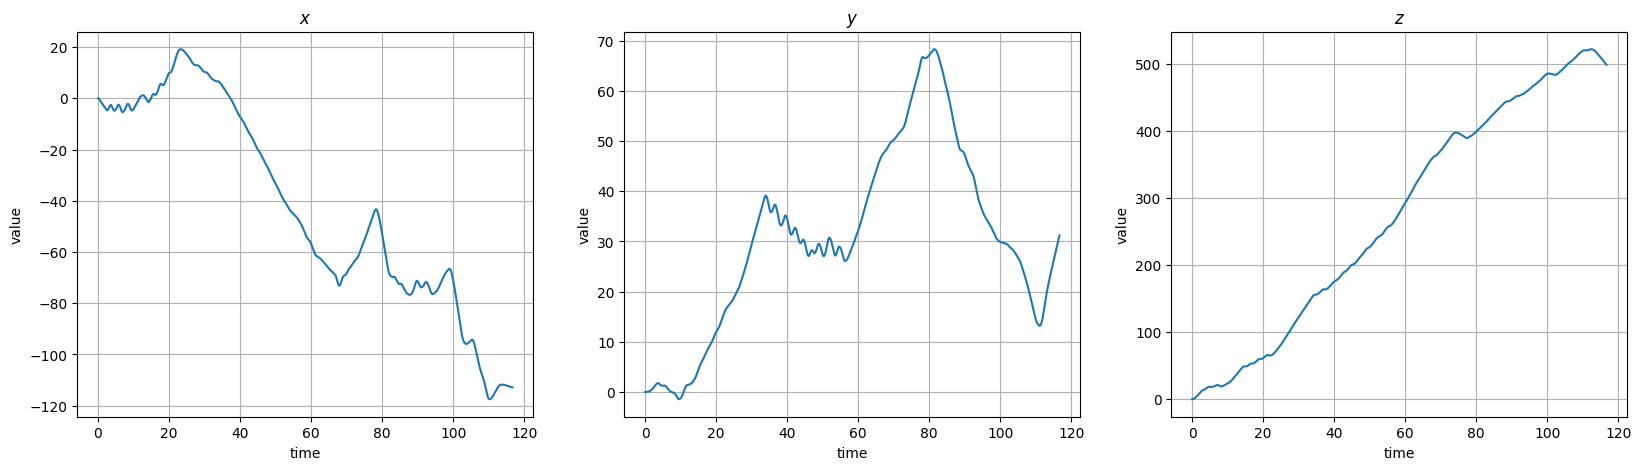

In [9]:
xData = np.column_stack([
    Integral(dt).apply([vx for (vx, vy, vz) in vData]),
    Integral(dt).apply([vy for (vx, vy, vz) in vData]),
    Integral(dt).apply([vz for (vx, vy, vz) in vData])
])

plotData(tData, {
    'x': [x for (x, y, z) in xData],
    'y': [y for (x, y, z) in xData],
    'z': [z for (x, y, z) in xData],
})

# ÂNGULAÇÃO

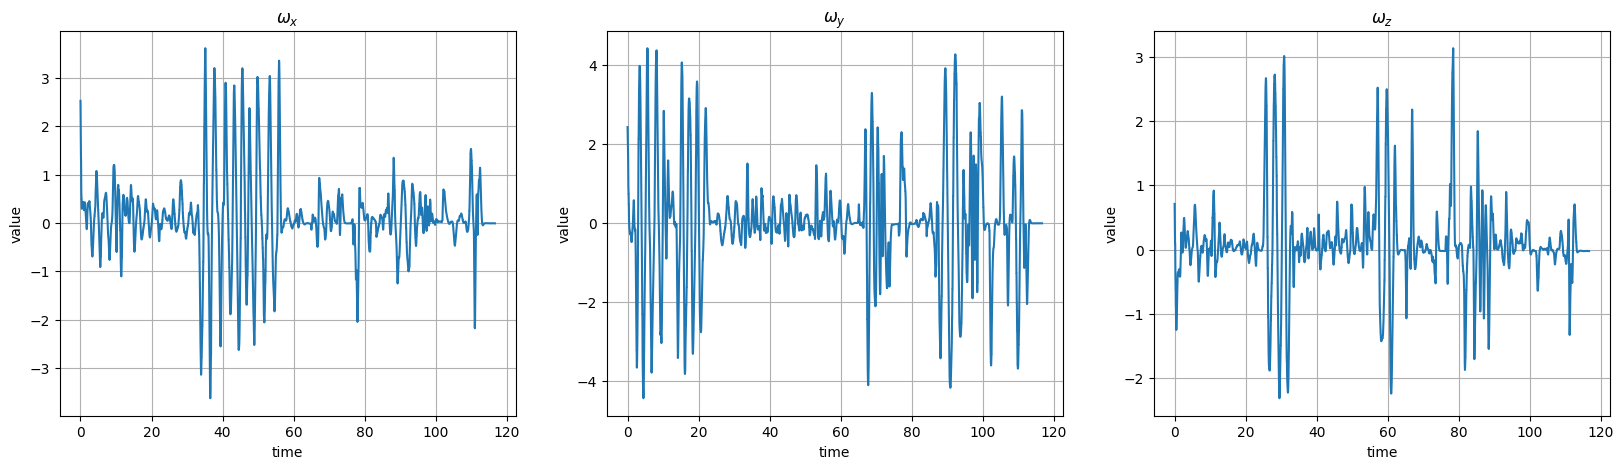

In [10]:
plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
})

### Ângulo (integração)

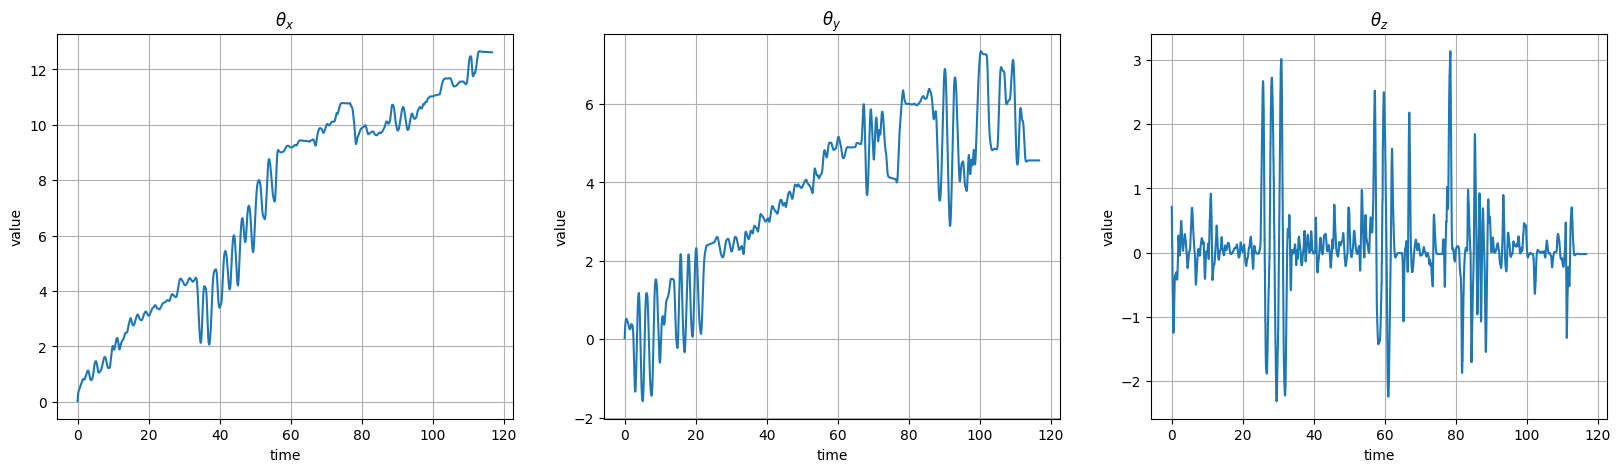

In [11]:
oData = np.column_stack([
    Integral(dt).apply([wx for (wx, wy, wz) in wData]),
    Integral(dt).apply([wy for (wx, wy, wz) in wData]),
    Integral(dt).apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    r'\theta_x': [ox for (ox, oy, oz) in oData],
    r'\theta_y': [oy for (ox, oy, oz) in oData],
    r'\theta_z': [oz for (ox, oy, oz) in wData],
})

### Campo Vetorial

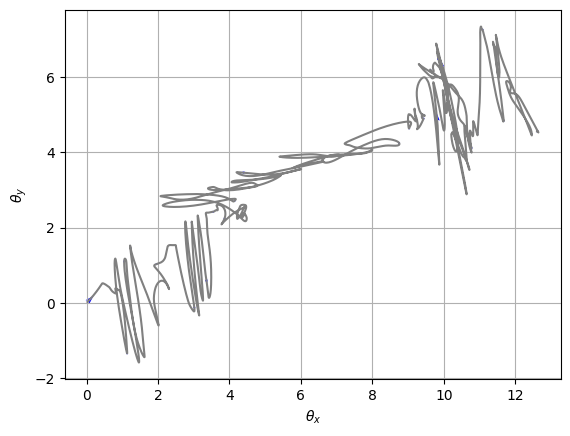

In [12]:
indices = np.linspace(0, len(oData)-1, 40, dtype=int)
x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], color='gray')
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=15, width=0.004, color='blue')
plt.xlabel(r'$\theta_x$'), plt.ylabel(r'$\theta_y$'), plt.grid()
plt.show()

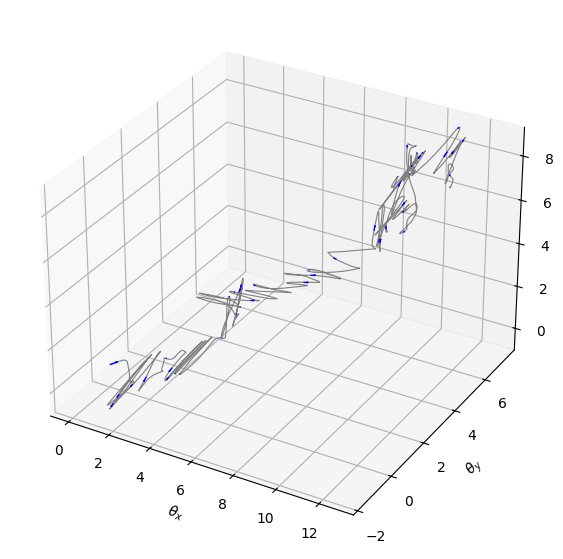

In [13]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(oData)-1, 50, dtype=int)

x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
z = np.array([oz for (ox, oy, oz) in oData])[indices]

u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]
w = np.array([wz for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], [oz for (ox, oy, oz) in oData], lw=0.8, color='gray')
ax.quiver(x, y, z, u, v, w, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel(r'$\theta_x$'), ax.set_ylabel(r'$\theta_y$'), ax.set_zlabel(r'$\theta_z$')
plt.show()

# ROW, PITCH, YAW

In [14]:
import math

def sign(x):
    return 1 if x >= 0 else -1

class Quaternions:
    def __init__(self):
        self.q   = np.array([1.0, 0.0, 0.0, 0.0])
        self.q_a = np.array([1.0, 0.0, 0.0, 0.0])
        self.pitch = self.roll = self.yaw = 0

    def product(self, q1, q2):
        w1, x1, y1, z1 = q1.data
        w2, x2, y2, z2 = q2.data

        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        return np.array([w, x, y, z])
    
    def euler(self, qData):
        q0, q1, q2, q3 = qData.data
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (q0 * q1 + q2 * q3)
        cosr_cosp = 1 - 2 * (q1**2 + q2**2)
        roll = math.atan2(sinr_cosp, cosr_cosp)
        
        # Pich (y-axis rotation)
        sinp  = 2*(q0 * q2 - q3 * q1)
        pitch = sign(sinp)*(math.pi/2) if abs(sinp) >= 1 else math.asin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (q0 * q3 + q1 * q2)
        cosy_cosp = 1 - 2 * (q2**2 + q3**2)
        yaw = math.atan2(siny_cosp, cosy_cosp)
        return (pitch, roll, yaw)

    def fromOmega(self, wx, wy, wz):
        omega = np.array([0.0, wx, wy, wz])
        q_dot = self.product(self.q, omega)
        self.q = q_dot*0.5*dt + self.q
        self.q = self.q / np.linalg.norm(self.q)
        return self.euler(self.q)

    def fromAccel(self, ax, ay, az):
        a = np.array([ax, ay, az])
        ax, ay, az = a / np.linalg.norm(a)
        pitch = math.atan2(-ax, math.sqrt(ay**2 + az**2))
        roll  = math.atan2(ay, az)
        yaw   = 0  # sem magnetômetro
        
        qroll  = np.array([math.cos(roll/2),  math.sin(roll/2), 0, 0])
        qpitch = np.array([math.cos(pitch/2), 0, math.sin(pitch/2), 0])
        qyaw   = np.array([math.cos(yaw/2),   0, 0, math.sin(yaw/2)])

        #q = q_yaw ⊗ (q_pitch ⊗ q_roll)
        q_temp   = self.product(qpitch, qroll)
        self.q_a = self.product(qyaw, q_temp)
        return self.euler(self.q_a)


q = Quaternions()

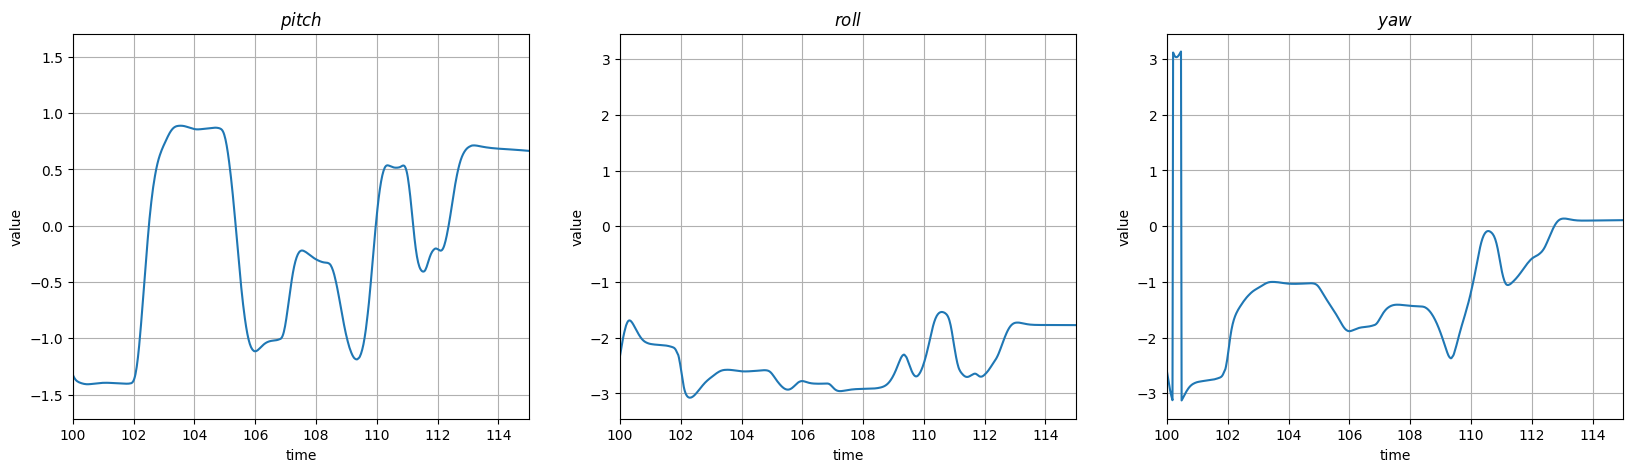

In [15]:
eulerData = []

for a, w in zip(aData, wData):
    ax, ay, az = a 
    wx, wy, wz = w 
    pitch, roll, yaw = q.fromOmega(wx, wy, wz)
    eulerData.append([pitch, roll, yaw])


plotData(tData, {
    r'pitch': [pitch for (pitch, roll, yaw) in eulerData],
    r'roll' : [roll for (pitch, roll, yaw) in eulerData],
    r'yaw'  : [yaw for (pitch, roll, yaw) in eulerData],
}, range=(100, 115))

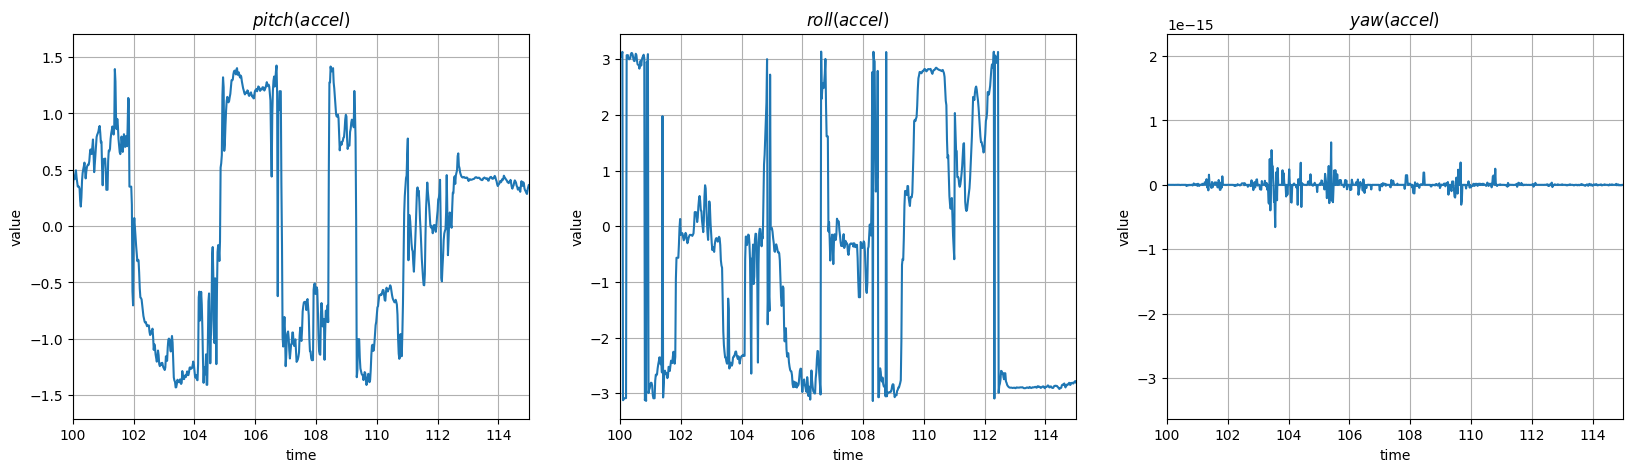

In [16]:
eulerData = []

for a, w in zip(aData, wData):
    ax, ay, az = a 
    wx, wy, wz = w 
    pitch, roll, yaw = q.fromAccel(ax, ay, az)
    eulerData.append([pitch, roll, yaw])


plotData(tData, {
    r'pitch (accel)': [pitch for (pitch, roll, yaw) in eulerData],
    r'roll (accel)' : [roll for (pitch, roll, yaw) in eulerData],
    r'yaw (accel)'  : [yaw for (pitch, roll, yaw) in eulerData],
}, range=(100, 115))

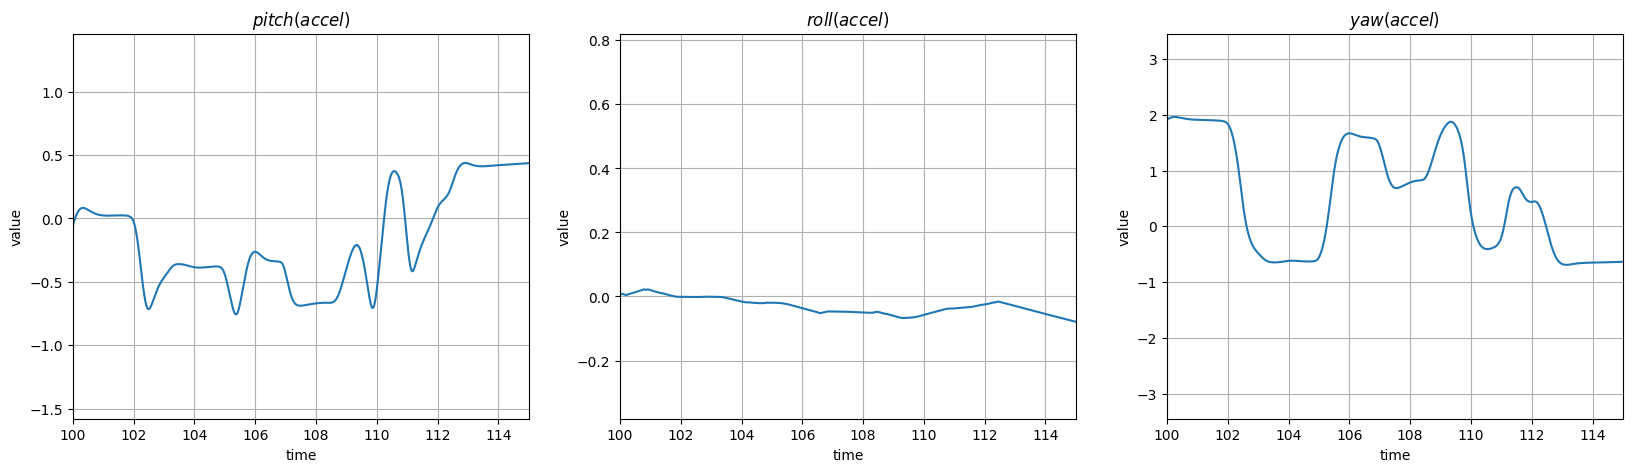

In [17]:
class KalmanFilter:
    def __init__(self, q=1.1, r=1.1, x0=0.0, dt=0.02):
        self.q = q          # process noise   (rad²)
        self.r = r          # measurement noise (rad²)
        self.x = x0         # state (angle)
        self.p = 1.0        # state covariance
        self.dt = dt

    def predict(self, w):
        self.x += w * self.dt
        self.p += self.q

    def update(self, z):
        k = self.p / (self.p + self.r)
        self.x += k * (z - self.x)
        self.p = (1.0 - k) * self.p
        return self.x


kf_pitch = KalmanFilter(dt=dt)
kf_roll  = KalmanFilter(dt=dt)
eulerData = []

for i, (a, w) in enumerate(zip(aData, wData)):
    ax, ay, az = a 
    wx, wy, wz = w 
    pitch_w, roll_w, yaw_w = q.fromOmega(wx, wy, wz)
    pitch_a, roll_a, yaw_a = q.fromAccel(ax, ay, az)

    pitch = kf_pitch.update(pitch_a)
    roll  = kf_roll.update(roll_a)
    eulerData.append([pitch_w, roll, yaw_w])

plotData(tData, {
    r'pitch (accel)': [pitch for (pitch, roll, yaw) in eulerData],
    r'roll (accel)' : [roll for (pitch, roll, yaw) in eulerData],
    r'yaw (accel)'  : [yaw for (pitch, roll, yaw) in eulerData],
}, range=(100, 115))